In [2]:
#import all the needed dependancies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import time
from IPython.display import clear_output

In [3]:
def CleanData(df):
    #To remove entries which have inappropriate date
    l = list(df['date'])
    for s in l:
        if type(s) is not int:
            df = df.drop(l.index(s))
    #To remove entries which have a severity level of 0
    df = df.drop(int(df[df['svrty_level']==0]['ID']))
    
    #To remove candidates whose units are always the same. we assumed them to be junk!
    SegDataFrames = SeggregateByCandidate(df)
    for i in SegDataFrames.keys():
        Y = list(SegDataFrames[i]['df']['units'])
        if(max(Y)==min(Y)):
            df = df[df['candidate']!=i]
    return df

In [4]:
def SeggregateByCandidate(df):
    DataFrames = {}
    #Seggregate the data into individual and separate data frames based on their candidate names
    keys = set(df['candidate'])
    for key in keys:
        temp = df[df['candidate']==key]
        DataFrames[key]= {}
        DataFrames[key]['df'] = temp
        DataFrames[key]['model'] = None
    return DataFrames

In [32]:
def PlotCandidateUnitVsTime(candidate):
    #Collect all date values from the data frame.
    X = list(SegDataFrames[candidate]['df']['date'])
    #Collect all the unit values from the data frame.
    Y = list(SegDataFrames[candidate]['df']['units'])
    #Calculate the threshold of the observed trend.
    t = Threshold(candidate)
    #Plot the graph
    plt.plot(X,Y,'b')
    plt.plot(X,[t]*len(X),'r',ls=('dashed'), lw=2)
    plt.xlabel("Date")
    plt.ylabel("Units")
    plt.title(candidate)
    plt.legend(["Unit Trend","Threshold"],loc="lower right")
    plt.show()
    

In [6]:
def Threshold(candidate):
    #Acquire the unit values from the data frame
    Y = list(SegDataFrames[candidate]['df']['units'])
    #Calculate the standard deviation of the units
    sigma = (np.var(Y))**0.5
    #Set threshold as given below
    Threshold = max(Y) + sigma*0.5
    return Threshold

In [7]:
def VisualiseCandidates(SegDataFrames):
    keys = sorted(SegDataFrames.keys())
    #Display the graphs of units vs date like a canvas with an interval of 0.5 seconds
    for key in keys:
        PlotCandidateUnitVsTime(key)
        time.sleep(0.5)
        clear_output(wait=True)

In [8]:
def TrainModels(SegDataFrames):
    keys = sorted(SegDataFrames.keys())
    for key in keys:
        LinReg = LinearRegression()
        #Train the linear regression model with 3 parameters
        X = SegDataFrames[key]['df'][['units','occur_count','svrty_level']]
        Y = SegDataFrames[key]['df']['date']
        LinReg.fit(X,Y)
        SegDataFrames[key]['model'] = LinReg
        #store the trained model into the dictionary of seggregated data frames.

In [22]:
def PredictFailure(candidate,units,occur_count,severity):
    #calculate the tentative time when the failure would occur
    a = float(SegDataFrames[candidate]['model'].predict([[Threshold(candidate),1,1]]))
    #calculate the tentative current time with the given data
    b = float(SegDataFrames[candidate]['model'].predict([[units,occur_count,severity]]))
    #return the time difference which is assumed to be in minutes, converted to number of days until failure
    return round(abs(a-b)/1440,1) # days to failure

In [83]:
def CalculateSlope(candidate):
    dates = list(SegDataFrames[candidate]['df']['date'])
    units = list(SegDataFrames[candidate]['df']['units'])
    dslopes = []
    uslopes = []
    for i in range(len(dates)-1):
        if(dates[i]!=dates[i+1]):
            dslopes.append((dates[i+1]-dates[i]))
            uslopes.append((units[i+1]-units[i]))
    ndslopes = []
    nuslopes = []
    np.mean(dslopes)
    for i in range(len(dslopes)):
        if dslopes[i]<=np.mean(dslopes):
            ndslopes.append(dslopes[i])
            nuslopes.append(uslopes[i])
    slopes = []
    for i in range(len(ndslopes)):
        slopes.append(nuslopes[i]/ndslopes[i])
    return np.mean(slopes)

In [87]:
def PredictRunningTimeFailure(candidate,units):
    slope = CalculateSlope(candidate)
    dely = Threshold(candidate)-units
    time = dely / slope
    return round(time/60,2)#return value in hours

In [9]:
df = pd.read_excel("CAT_Training_Dataset_V3 File.xlsx",engine='openpyxl')

In [10]:
CleanedDataFrame = CleanData(df)

In [11]:
SegDataFrames = SeggregateByCandidate(CleanedDataFrame)

In [28]:
TrainModels(SegDataFrames)

In [97]:
while(True):
    candidate = input("Enter Candidate name: ")
    units = eval(input("Enter units: "))
    occ = eval(input("Enter occurence count: "))
    sev = eval(input("Enter severity level: "))
    
    time = PredictFailure(candidate,units,occ,sev)
    print("Your machine will fail in approximately ",time," days!")
    
    if(input("Would you like to continue?(y/n): ")!='y'):
        break

Enter Candidate name: ABCDE00033
Enter units: 3341
Enter occurence count: 2
Enter severity level: 2
Your machine will fail in approximately  4.2  days!
Would you like to continue?(y/n): n


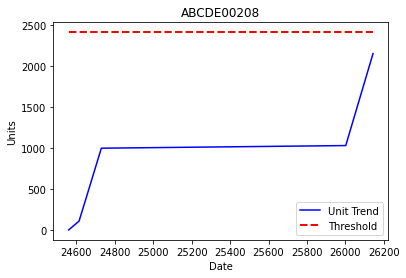

In [38]:
PlotCandidateUnitVsTime('ABCDE00208')

In [91]:
CalculateSlope('ABCDE00208')

7.796776729559749

In [102]:
while(True):
    candidate = input("Enter Candidate name: ")
    units = eval(input("Enter units: "))

    
    time = PredictRunningTimeFailure(candidate,units)
    print("Your machine will fail in approximately ",time," hours, if run continuously!")
    
    if(input("Would you like to continue?(y/n): ")!='y'):
        break

Enter Candidate name: ABCDE00024
Enter units: 3500
Your machine will fail in approximately  43.05  hours, if run continuously!
Would you like to continue?(y/n): n


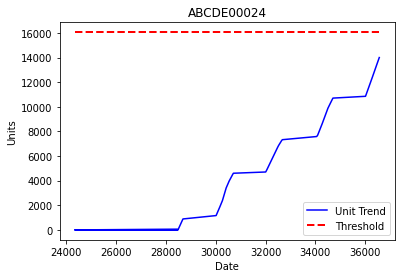

In [103]:
PlotCandidateUnitVsTime('ABCDE00024')

In [104]:
CalculateSlope('ABCDE00024')

4.85946358093804